In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline



Using TensorFlow backend.


In [0]:
def set_pandas_options():
    import warnings
    pd.options.display.max_columns = 128
    pd.options.display.max_rows = 128
    pd.options.display.float_format = '{:.9f}'.format
    pd.options.mode.chained_assignment = None
    warnings.simplefilter(action='ignore', category=FutureWarning)
set_pandas_options()

In [4]:

%cd /content/drive/My Drive/Machine Learning

/content/drive/My Drive/Machine Learning


## 1. Data Understanding

In [0]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [9]:
print(train.shape)
print(test.shape)

(59381, 128)
(19765, 127)


In [10]:
train.columns

Index(['Id', 'Product_Info_1', 'Product_Info_2', 'Product_Info_3',
       'Product_Info_4', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7',
       'Ins_Age', 'Ht',
       ...
       'Medical_Keyword_40', 'Medical_Keyword_41', 'Medical_Keyword_42',
       'Medical_Keyword_43', 'Medical_Keyword_44', 'Medical_Keyword_45',
       'Medical_Keyword_46', 'Medical_Keyword_47', 'Medical_Keyword_48',
       'Response'],
      dtype='object', length=128)

In [11]:
train.isna().sum()

Id                         0
Product_Info_1             0
Product_Info_2             0
Product_Info_3             0
Product_Info_4             0
Product_Info_5             0
Product_Info_6             0
Product_Info_7             0
Ins_Age                    0
Ht                         0
Wt                         0
BMI                        0
Employment_Info_1         19
Employment_Info_2          0
Employment_Info_3          0
Employment_Info_4       6779
Employment_Info_5          0
Employment_Info_6      10854
InsuredInfo_1              0
InsuredInfo_2              0
InsuredInfo_3              0
InsuredInfo_4              0
InsuredInfo_5              0
InsuredInfo_6              0
InsuredInfo_7              0
Insurance_History_1        0
Insurance_History_2        0
Insurance_History_3        0
Insurance_History_4        0
Insurance_History_5    25396
Insurance_History_7        0
Insurance_History_8        0
Insurance_History_9        0
Family_Hist_1              0
Family_Hist_2 

In [12]:
print('proportion of nan values in train set : ')
prop = train.isnull().sum(axis = 0)/len(train)
prop[prop != 0.0]

proportion of nan values in train set : 


Employment_Info_1     0.000319968
Employment_Info_4     0.114161095
Employment_Info_6     0.182785740
Insurance_History_5   0.427678887
Family_Hist_2         0.482578603
Family_Hist_3         0.576632256
Family_Hist_4         0.323066301
Family_Hist_5         0.704114111
Medical_History_1     0.149694347
Medical_History_10    0.990619895
Medical_History_15    0.751014634
Medical_History_24    0.935989626
Medical_History_32    0.981357673
dtype: float64

In [13]:
train['Response'].value_counts()

8    19489
6    11233
7     8027
2     6552
1     6207
5     5432
4     1428
3     1013
Name: Response, dtype: int64

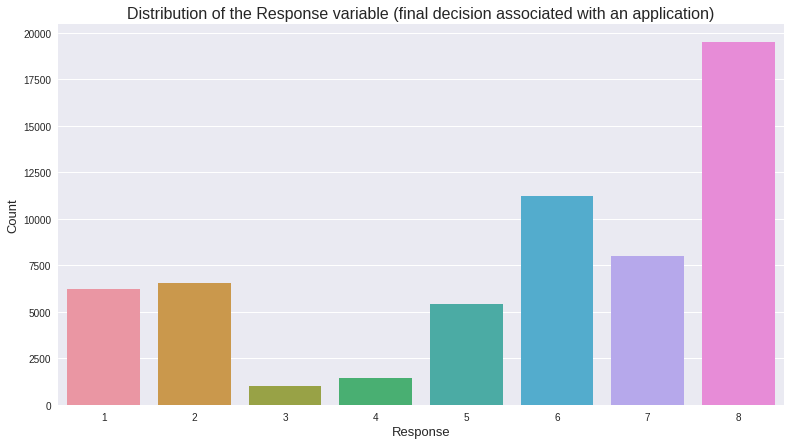

In [14]:
# response distribution
fig, ax = plt.subplots(1,1,figsize=(13,7))
sns.countplot(x='Response',data=train, ax=ax)
plt.xlabel('Response',fontsize=13)
plt.ylabel('Count',fontsize=13)
plt.title('Distribution of the Response variable (final decision associated with an application)',fontsize=16);

**Age, Height, Weight, BMI VS Response**

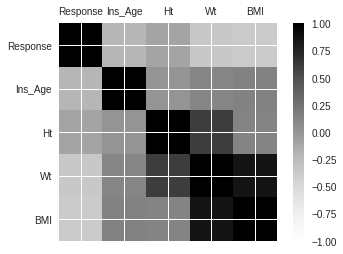

In [15]:
cols = ['Response', 'Ins_Age', 'Ht', 'Wt', 'BMI']
correlations = train[cols].corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,5,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(cols)
ax.set_yticklabels(cols)
plt.show()

In [0]:
## old graphs
# facet = sns.FacetGrid(train, hue="Response",aspect=4, hue_order=[1,2,3,4,5,6,7,8], palette="RdBu")
# facet.map(sns.kdeplot,'Ins_Age')
# facet.set(xlim=(0, train['Ins_Age'].max()))
# facet.add_legend();
# plt.xlabel('Age of applicant',fontsize=13)
# plt.title('Distribution of responses across normalized ages')

# facet = sns.FacetGrid(train, hue="Response",aspect=4, hue_order=[1,2,3,4,5,6,7,8], palette="RdBu")
# facet.map(sns.kdeplot,'Ht')
# facet.set(xlim=(0.4, train['Ht'].max()))
# facet.add_legend()
# plt.xlabel('Normalized Height of applicant',fontsize=13)
# plt.title('Distribution of responses across normalized Heights')

# facet = sns.FacetGrid(train, hue="Response",aspect=4, hue_order=[1,2,3,4,5,6,7,8], palette="RdBu")
# facet.map(sns.kdeplot,'Wt')
# facet.set(xlim=(0, train['Wt'].max()))
# facet.add_legend();
# plt.xlabel('Normalized Weight of applicant',fontsize=13)
# plt.title('Distribution of responses across normalized weights')

# facet = sns.FacetGrid(train, hue="Response",aspect=4, hue_order=[1,2,3,4,5,6,7,8], palette="RdBu")
# facet.map(sns.kdeplot,'BMI')
# facet.set(xlim=(0, 1.0))
# facet.add_legend()
# plt.xlabel('Normalized BMI of applicant',fontsize=13)
# plt.title('Distribution of responses across normalized BMI')

# fig, axes  = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
# sns.boxplot(x="Response", y="Ins_Age", data=train, order=[1,2,3,4,5,6,7,8], palette="RdBu",ax=axes[0,0])
# sns.boxplot(x="Response", y="Ht", data=train, order=[1,2,3,4,5,6,7,8], palette="RdBu",ax=axes[0,1])
# sns.boxplot(x="Response", y="Wt", data=train, order=[1,2,3,4,5,6,7,8], palette="RdBu",ax=axes[1,0])
# sns.boxplot(x="Response", y="BMI", data=train, order=[1,2,3,4,5,6,7,8], palette="RdBu",ax=axes[1,1])

## 2. Data Preprocessing

In [0]:
class StandardScaler_df:
    def __init__(self):
        self.StandardScaler = StandardScaler()
    def fit(self, df):
        self.StandardScaler.fit(df)
    def transform(self, df):
        df = pd.DataFrame(self.StandardScaler.transform(df), columns=df.columns)
        return df
    def fit_transform(self, df):
        df = pd.DataFrame(self.StandardScaler.fit_transform(df), columns=df.columns)
        return df

In [0]:
def make_dataset():
    train = pd.read_csv('data/train.csv')
    test = pd.read_csv('data/test.csv')
    labels = train['Response']
    train.drop(labels='Response',axis = 1, inplace=True)
    cols_to_drop = ['Id', 'Medical_History_10','Medical_History_15','Medical_History_24','Medical_History_32']
  
    train.drop(cols_to_drop, axis = 1, inplace = True)
    test.drop(cols_to_drop, axis = 1, inplace = True)
  
    df = pd.concat([train,test])
  
    cat_cols = ["Product_Info_1", "Product_Info_2", "Product_Info_3", "Product_Info_5", "Product_Info_6", 
               "Product_Info_7", "Employment_Info_2", "Employment_Info_3", "Employment_Info_5", "InsuredInfo_1",
               "InsuredInfo_2", "InsuredInfo_3", "InsuredInfo_4", "InsuredInfo_5", "InsuredInfo_6", "InsuredInfo_7", 
              "Insurance_History_1", "Insurance_History_2", "Insurance_History_3", "Insurance_History_4", "Insurance_History_7", 
              "Insurance_History_8", "Insurance_History_9", "Family_Hist_1", "Medical_History_2", "Medical_History_3", "Medical_History_4", 
              "Medical_History_5", "Medical_History_6", "Medical_History_7", "Medical_History_8", "Medical_History_9",
              "Medical_History_11", "Medical_History_12", "Medical_History_13", "Medical_History_14", "Medical_History_16", "Medical_History_17",
              "Medical_History_18", "Medical_History_19", "Medical_History_20", "Medical_History_21", "Medical_History_22", "Medical_History_23",
              "Medical_History_25", "Medical_History_26", "Medical_History_27", "Medical_History_28", "Medical_History_29", "Medical_History_30", 
              "Medical_History_31", "Medical_History_33", "Medical_History_34", "Medical_History_35", "Medical_History_36", 
               "Medical_History_37", "Medical_History_38", "Medical_History_39", "Medical_History_40", "Medical_History_41"]
  
  
    num_cols = ['Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6',
              'Insurance_History_5', 'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5','Medical_History_1']

  # fill Nan values with mode for categorical variables, median for continuous variables
    df = df.apply(lambda col: col.fillna(value = col.mode()[0] ) if col.name in cat_cols else col.fillna(value = col.median() ))
  
  # one-hot encoding categorical variables 
    dummies = pd.get_dummies(df, columns= cat_cols)
  
  # split data to train and test
    train = dummies[:train.shape[0]]
    test = dummies[train.shape[0]:]
  
  # scaling 
    scaler = StandardScaler_df()
    train[num_cols] = scaler.fit_transform(train[num_cols])
    test[num_cols] = scaler.transform(test[num_cols])
  
    return labels, train, test

In [0]:
labels, train, test = make_dataset()

In [20]:
print(labels.shape)
print(train.shape)
print(test.shape)

(59381,)
(59381, 948)
(19765, 948)


## 3. Models Building and evaluation

*   <font color='red'>**Logistic Regression**</font> 

In [34]:
# train logistic regression model
model_lr = LogisticRegression()
model_lr.fit(train, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
# Making predictions
test_preds = model_lr.predict(test)

In [0]:
# Make a submission
submission = pd.read_csv('data/sample_submission.csv')
submission["Response"] = test_preds
submission.to_csv('data/lr_submission.csv', index=False)

**The logistic regression model scored 0.48729 on kaggle.**





---





* <font color='red'>**XGBoost** </font> 

In [0]:
import xgboost as xgb


In [0]:
labels, train, test = make_dataset()

In [0]:
dtrain = xgb.DMatrix(train.values, labels.values)

In [0]:
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:linear',
    'eval_metric':"mae"
}

In [0]:
num_boost_round = 50

In [0]:
#Parameters max_depth and min_child_weight

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(5,7)
    for min_child_weight in range(2,4)
]

In [14]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=5, min_child_weight=2
	MAE 1.4384842 for 49 rounds
CV with max_depth=5, min_child_weight=3
	MAE 1.4378038 for 49 rounds
CV with max_depth=6, min_child_weight=2
	MAE 1.4332487999999999 for 49 rounds
CV with max_depth=6, min_child_weight=3
	MAE 1.4343024 for 49 rounds
Best params: 6, 2, MAE: 1.4332487999999999


In [0]:
# update params

params['max_depth'] = 6
params['min_child_weight'] = 2

In [0]:
# Parameters subsample and colsample_bytree

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(4,6)]
    for colsample in [i/10. for i in range(4,6)]
]

In [17]:
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=0.5, colsample=0.5
	MAE 1.4447132000000003 for 44 rounds
CV with subsample=0.5, colsample=0.4
	MAE 1.4478038 for 45 rounds
CV with subsample=0.4, colsample=0.5
	MAE 1.448769 for 46 rounds
CV with subsample=0.4, colsample=0.4
	MAE 1.4550662 for 49 rounds
Best params: 0.5, 0.5, MAE: 1.4447132000000003


In [0]:
# update params

params['subsample'] = 0.5
params['colsample_bytree'] = 0.5

In [0]:
# train xgb model
train_xgb = xgb.DMatrix(train.values, labels.values)
model_xgb = xgb.train(params, train_xgb,num_boost_round = 100)

In [0]:
# Making predictions
test_xgb  = xgb.DMatrix(test.values)
test_preds = model_xgb.predict(test_xgb,ntree_limit=model_xgb.best_iteration)
test_preds = np.round(np.clip(test_preds,1,8)).astype(int)

In [0]:
# Make a submission
submission = pd.read_csv('data/sample_submission.csv')
submission["Response"] = test_preds
submission.to_csv('data/xgb_submission.csv', index=False)

**The XGBoost model scored 0.56787 on kaggle .** 

 Note: we can reach a better result if we use a more wide range for hyperparameters and many of them but that needs time!

*  <font color='red'>**Neural Network**</font> 

In [0]:
class NN:
    def __init__(self, inputShape, layers, dropout = [], activation = 'relu', 
                 init = 'uniform', loss = 'rmse', optimizer = 'adadelta', nb_epochs = 50, batch_size = 32, verbose = 1):

        model = Sequential()
        for i in range(len(layers)):
            if i == 0:
                model.add(Dense(layers[i], input_dim = inputShape, init = init))
            else:
                model.add(Dense(layers[i], init = init))
            model.add(Activation(activation))
            model.add(BatchNormalization())
            if len(dropout) > i:
                model.add(Dropout(dropout[i]))
        model.add(Dense(1, init = init)) 
        model.compile(loss=loss, optimizer=optimizer)
        
        self.model = model
        self.nb_epochs = nb_epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y): 
        self.model.fit(X.values, y.values, nb_epoch=self.nb_epochs, batch_size=self.batch_size, verbose = self.verbose)
        
    def predict(self, X, batch_size = 128, verbose = 1):
        return self.model.predict(X.values, batch_size = batch_size, verbose = verbose)


In [0]:
# train Nerual network model
model_nn = NN(inputShape = train.shape[1], layers = [128, 64, 32], dropout = [0.5, 0.5, 0.7], loss='mae', optimizer = 'adadelta', init = 'glorot_normal', nb_epochs = 100)
model_nn.fit(train, labels)

Input shape: 948
Adding Layer 0: 128
Adding relu layer
Adding 0.5 dropout
Adding Layer 1: 64
Adding relu layer


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_dim=948, kernel_initializer="glorot_normal")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, kernel_initializer="glorot_normal")`
  del sys.path[0]


Adding 0.5 dropout
Adding Layer 2: 32
Adding relu layer
Adding 0.7 dropout


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, kernel_initializer="glorot_normal")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="glorot_normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/100
59381/59381 [==============================] - 23s 393us/step - loss: 2.5981
Epoch 2/100
59381/59381 [==============================] - 21s 352us/step - loss: 1.8635
Epoch 3/100
59381/59381 [==============================] - 21s 352us/step - loss: 1.7423
Epoch 4/100
59381/59381 [==============================] - 21s 353us/step - loss: 1.6581
Epoch 5/100
59381/59381 [==============================] - 21s 351us/step - loss: 1.6049
Epoch 6/100
59381/59381 [==============================] - 21s 353us/step - loss: 1.5561
Epoch 7/100
59381/59381 [==============================] - 21s 352us/step - loss: 1.5283
Epoch 8/100
59381/59381 [==============================] - 21s 353us/step - loss: 1.5093
Epoch 9/100
59381/59381 [==============================] - 21s 353us/step - loss: 1.4896
Epoch 10/100
59381/59381 [==============================] - 21s 350us/step - loss: 1.4806
Epoch 11/100
59381/59381 [==============================] - 21s 351us/step - loss: 1.4754
Epoch 12/100
59381/

In [0]:
# Making predictions
test_preds = model_nn.predict(test)
test_preds = np.clip(np.round(test_preds), 1, 8).astype(int)

19765/19765 [==============================] - 1s 26us/step


In [0]:
# Make a submission
submission = pd.read_csv('data/sample_submission.csv')
submission["Response"] = test_preds
submission.to_csv('data/nn_submission.csv', index=False)

**The Deep neural network model scored 0.57065 on kaggle.**  